In [1]:
import time
import torch
import torchvision.models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

In [2]:
BATCH_SIZE = 3
EPOCHS = 32
DEVICE = torch.device("cuda:0")
N_CLASSES = 1000
LEAF_CLASS = 48

In [3]:
#torch.multiprocessing.set_start_method('spawn')

In [4]:
import os
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader

class LeafClassificationDataset(Dataset):
    def __init__(self, dir, transforms=None, default_label=1):
        self.files = [os.path.join(dir, file) for file in os.listdir(dir) if os.path.isfile(os.path.join(dir, file)) and file.endswith(("jpg", "jpeg", "png"))]
        self.transforms = transforms
        self.default_label = default_label

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        image = read_image(self.files[idx])
        label = self.default_label
        if self.transforms:
            image = self.transforms(image)
        return image, label

In [5]:


tf_simple = transforms.Compose([
    transforms.ConvertImageDtype(torch.float32),
    transforms.Resize((512, 512))
])
dataset = LeafClassificationDataset("_data/urban_street/images", transforms=tf_simple, default_label=LEAF_CLASS)

def collate_fn(batch):
    xs, ys = zip(*batch)
    #return torch.stack(xs).to(DEVICE), torch.tensor(ys).to(DEVICE)
    return torch.stack(xs), torch.tensor(ys)
dataloader = DataLoader(dataset,
                        shuffle=True,
                        batch_size=BATCH_SIZE,
                        num_workers=2,
                        collate_fn=collate_fn)

In [6]:
model = torchvision.models.convnext_base(weights="DEFAULT", num_classes=N_CLASSES)
model = model.to(DEVICE)

In [7]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [8]:
import pandas as pd
loss_df = pd.DataFrame({}, columns=["step", "epoch", "loss"])

In [9]:
tf_net = torch.nn.Sequential(
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(.5),
    transforms.RandomPerspective(distortion_scale=0.6)
).to(DEVICE)

In [13]:
import tqdm
step = 0
for epoch in range(EPOCHS):
    print(f"Starting Epoch {epoch}")
    running_loss = 0.0
    p_bar = tqdm.tqdm(dataloader)
    for batch in p_bar:
        step += len(batch)
        inputs, labels = batch
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        optimizer.zero_grad()

        outputs = model(tf_net(inputs))
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        p_bar.set_description(f"Loss: {loss.item()}, Probabilities: {outputs[:, -1]}")
    print(f"Epoch {epoch} Loss: ", running_loss)
    print("Saving Model Checkpoint")
    torch.save(model, f"out/resnet_leaf_classifier/epoch_{epoch}.pt")
    
print("Finished Training, Saving Model")
torch.save(model, f"out/resnet_leaf_classifier/{time.time()}.pt")

Starting Epoch 0


Loss: 4.2516912799328566e-05, Probabilities: tensor([17.6247, 17.4106, 16.6225], device='cuda:0', grad_fn=<SelectBackward0>):   1%|          | 34/3255 [00:20<32:01,  1.68it/s]


KeyboardInterrupt: 

In [11]:
torch.save(model, f"out/resnet_leaf_classifier/{time.time()}.pt")

In [14]:
PROB_THRESHOLD = .8

In [15]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=DEVICE)

mask_generator = SamAutomaticMaskGenerator(sam)

/home/stefan.steinheber/.conda/envs/pt_12.4/lib/python3.12/site-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.

In [17]:
import random
import os
import cv2
image_file = random.sample(os.listdir("_data/combined/test"), 1)[0]
image = cv2.imread(os.path.join("_data/combined/test", image_file))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [40]:
masks = mask_generator.generate(image)
print(f"Detected {len(masks)} areas")

Detected 166 areas


In [41]:
tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float32),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),  
])

leaf_masks = []

for mask in masks:
    bbox = mask["bbox"]
    if bbox[2] - bbox[0] == 0 or  bbox[3] - bbox[1] == 0:
        continue
    crop = image[bbox[0]:bbox[2], bbox[1]:bbox[3], :]
    if crop.shape[0] == 0 or crop.shape[1] == 0:
        continue
    crop = tf(crop)
    crop = crop.unsqueeze(0)
    crop = crop.to(DEVICE)
    result = model(crop)
    probabilities = torch.nn.functional.softmax(result[0], dim=0)
    if probabilities[LEAF_CLASS] > PROB_THRESHOLD:
        leaf_masks.append(mask)
print(f"Detected {len(leaf_masks)} leaf areas")

Detected 12 leaf areas


In [42]:
import numpy as np
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

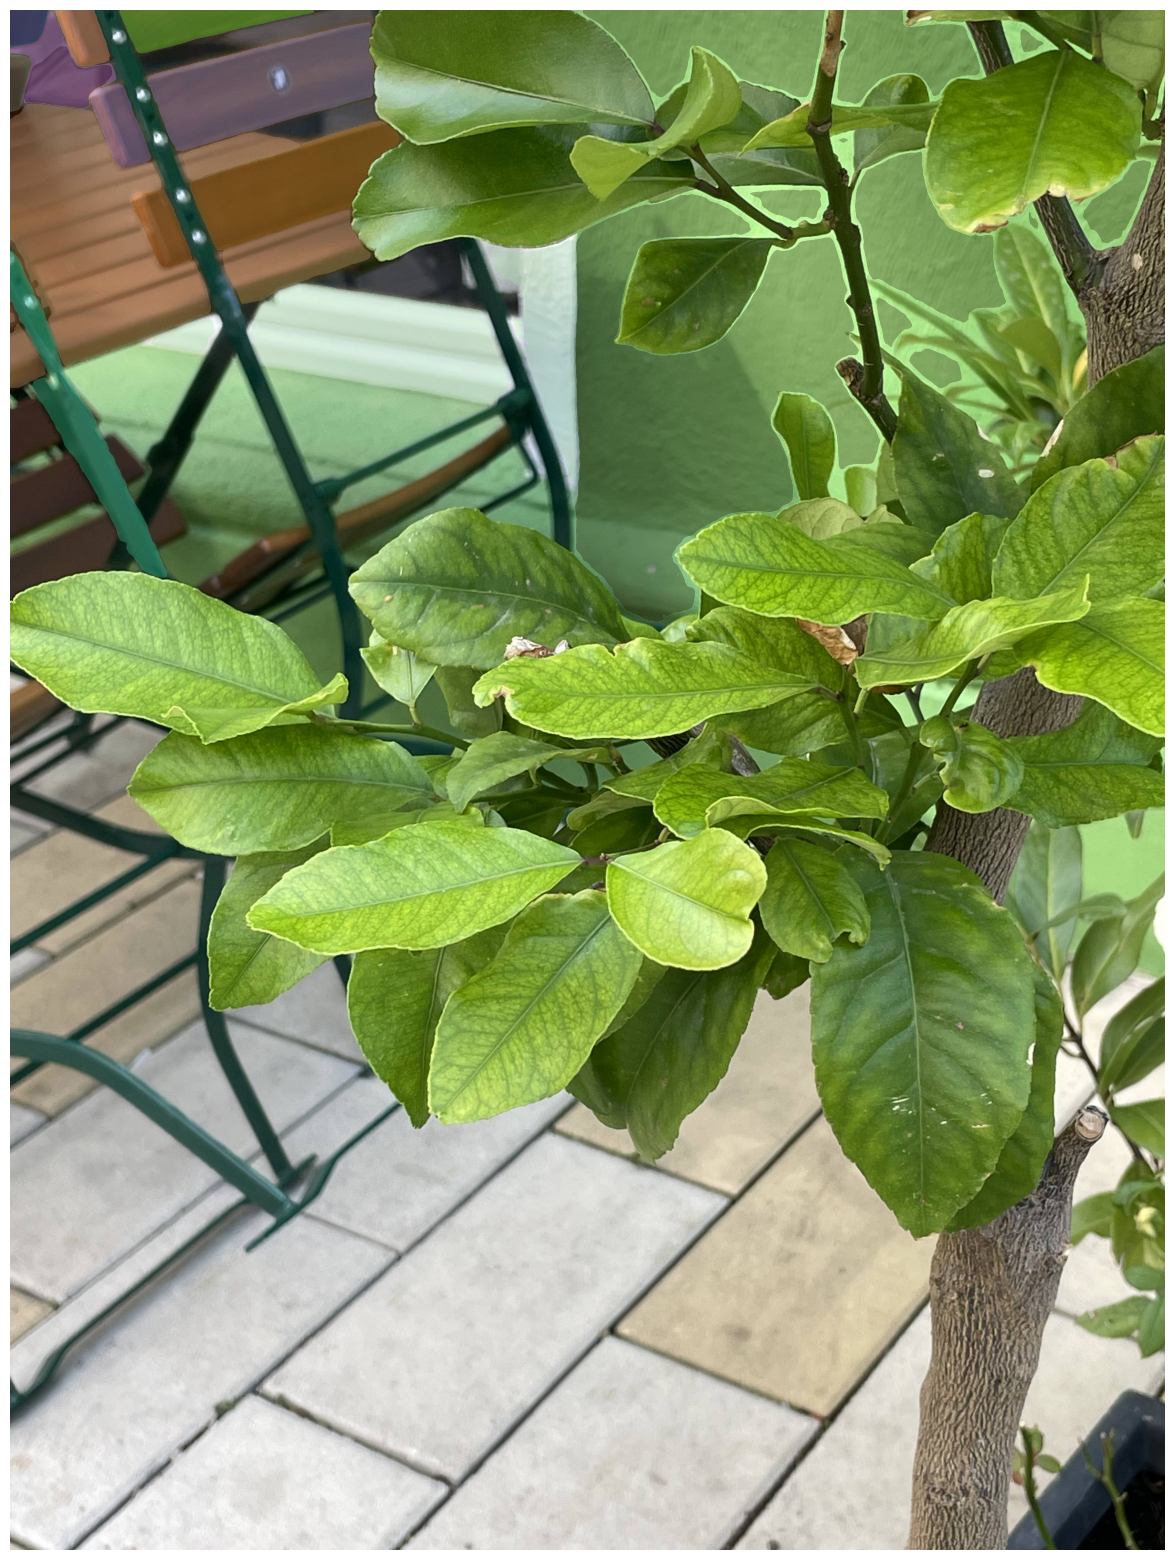

In [43]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(leaf_masks)
plt.axis('off')
plt.show() 